In [7]:
# ========================= 📚 导入必要的库 =========================
# 系统与工具库
import os  # 处理文件路径和目录操作
import random  # 生成随机数，用于随机种子
import numpy as np  # 科学计算库
import matplotlib.pyplot as plt  # 数据可视化
import seaborn as sns  # 高级可视化库，通常与Matplotlib配合使用
from math import cos, pi  # 数学函数
from tqdm import tqdm  # 显示进度条，方便观察训练过程

# 深度学习相关库
import torch  # PyTorch主库
import torch.nn as nn  # 神经网络模块
import torch.nn.functional as F  # 常用神经网络函数（如激活函数、损失函数等）
import torch.optim as optim  # 优化器模块
from torch.cuda import amp  # 自动混合精度训练（加速训练，减少显存使用）
from torch.utils.data import DataLoader  # 数据加载器，用于批量加载数据

# 图像数据处理
from torchvision import transforms, datasets  # 数据增强和常用数据集
from torchvision.transforms import RandAugment  # 自动数据增强工具

# 评估指标
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)  # 计算分类任务的性能指标

# ========================= 🎯 设置随机种子 =========================
def set_seed(seed=42):
    """
    设置全局随机种子，确保实验结果可复现。
    """
    random.seed(seed)  # Python内置的随机数生成器
    np.random.seed(seed)  # Numpy随机数生成器
    torch.manual_seed(seed)  # PyTorch CPU随机数生成器
    torch.cuda.manual_seed(seed)  # PyTorch GPU随机数生成器
    torch.cuda.manual_seed_all(seed)  # 多GPU随机数生成器
    torch.backends.cudnn.deterministic = True  # 保证CUDA的确定性行为
    torch.backends.cudnn.benchmark = False  # 禁用自动优化，以确保一致性

# 调用随机种子函数
set_seed(42)

# ========================= 💻 选择计算设备 =========================
# 根据硬件情况选择GPU或CPU进行训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)  # 将设备转化为PyTorch可用格式
print("Using device:", device)

# ========================= 🖼️ 数据增强与预处理 =========================

# 📌 **训练集数据增强**
# 使用一系列数据增强操作，增加数据多样性，提高模型泛化能力
img_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50%的概率水平翻转图像
    transforms.RandomRotation(degrees=15),  # 随机旋转角度范围[-15°, 15°]
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 随机裁剪并调整到224x224
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.1),  # 调整亮度、对比度等
    transforms.RandomGrayscale(p=0.1),  # 10%的概率将图像转为灰度
    transforms.ToTensor(),  # 将图像转换为PyTorch张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化到ImageNet均值和标准差
])

# 📌 **验证集和测试集数据预处理**
# 通常验证集和测试集不需要进行复杂的数据增强，确保评估结果稳定
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小为224x224
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# ========================= 📂 加载数据集 =========================
# 从指定路径加载训练、验证和测试数据集
train_dataset = datasets.ImageFolder(root='animal_10/train', transform=img_transforms)
val_dataset = datasets.ImageFolder(root='animal_10/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='animal_10/test', transform=val_test_transform)

# 打印数据集大小信息
print("Dataset sizes:",
      f"train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

# ========================= 🚚 数据加载器 =========================
# 使用DataLoader批量加载数据，提高训练效率
batch_size = 32  # 每批加载32张图片
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# 打印加载器的批次数量
print(f"train_loader={len(train_loader)}, val_loader={len(val_loader)}, test_loader={len(test_loader)}")

# ========================= 🔀 MixUp & CutMix =========================
# 📌 **MixUp数据增强函数**
def mixup_data(x, y, alpha=1.0):
    """
    实现MixUp数据增强，混合两张图像及其标签。
    Args:
        x: 图像张量
        y: 标签张量
        alpha: Beta分布的alpha参数，控制混合程度
    Returns:
        混合后的图像和标签
    """
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)  # 从Beta分布中采样lambda值
    index = torch.randperm(x.size(0)).to(x.device)  # 随机打乱索引
    mixed_x = lam * x + (1 - lam) * x[index, :]  # 按比例混合图像
    y_a, y_b = y, y[index]  # 获取对应的标签
    return mixed_x, y_a, y_b, lam

# 📌 **CutMix数据增强函数**
def cutmix_data(x, y, alpha=1.0):
    """
    实现CutMix数据增强，通过随机裁剪和拼接图像进行增强。
    """
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)  # 从Beta分布中采样lambda值
    rand_index = torch.randperm(x.size(0)).to(x.device)  # 随机打乱索引
    y_a = y
    y_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)  # 生成裁剪区域
    x[:, :, bby1:bby2, bbx1:bbx2] = x[rand_index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - (bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2))
    return x, y_a, y_b, lam


Using device: cuda
Dataset sizes: train=14720, val=1840, test=1840
train_loader=230, val_loader=29, test_loader=29


In [8]:
class ECAAttention(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECAAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 自适应平均池化，将特征图缩减到 1x1
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1)//2, bias=False)  # 使用1D卷积捕获通道注意力
        self.sigmoid = nn.Sigmoid()  # 激活函数，将输出映射到(0,1)之间

    def forward(self, x):
        b, c, h, w = x.size()  # 获取批量大小、通道数、高度、宽度
        y = self.avg_pool(x)  # 对每个通道进行全局平均池化，尺寸变为 (B, C, 1, 1)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        # squeeze: 移除最后一个维度
        # transpose: 转换维度，使通道作为时间步传入1D卷积
        # unsqueeze: 恢复原来的形状
        y = self.sigmoid(y)  # 通过Sigmoid激活
        return x * y  # 将注意力权重与输入特征逐通道相乘
def conv_bn(inp, oup, kernel_size, stride=1, activation=nn.Hardswish):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size, stride, (kernel_size // 2), bias=False),  # 2D卷积层
        nn.BatchNorm2d(oup),  # 批标准化，稳定训练
        activation(inplace=True)  # 使用 Hardswish 作为激活函数
    )

class InvertedResidualECA(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_eca=False):
        super(InvertedResidualECA, self).__init__()
        self.stride = stride
        hidden_dim = int(round(inp * expand_ratio))  # 根据扩展比例计算中间层通道数
        self.use_res_connect = (self.stride == 1 and inp == oup)  # 判断是否使用残差连接

        layers = []
        activation = nn.Hardswish

        # 1x1 卷积：通道扩展
        if expand_ratio != 1:
            layers.append(conv_bn(inp, hidden_dim, 1, 1, activation))

        # 3x3 深度可分离卷积
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(activation(inplace=True))

        # 如果启用ECA注意力机制
        if use_eca:
            layers.append(ECAAttention(hidden_dim))

        # 1x1 卷积：通道压缩
        layers.append(nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False))
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            return x + out  # 使用残差连接
        else:
            return out

class LiteIResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LiteIResNet, self).__init__()
        self.stem = conv_bn(3, 16, 3, 2)  # 初始特征提取层

        # 配置每个块的参数 (扩展比例, 输出通道, 重复次数, 步长, 是否使用ECA)
        block_setting = [
            (1, 16, 1, 1, False),
            (4, 24, 2, 2, False),
            (4, 32, 3, 2, False),
            (4, 64, 3, 2, True),
            (6, 96, 2, 1, True),
            (6, 128, 2, 2, True),
        ]

        input_channel = 16
        features = []
        for t, c, n, s, eca in block_setting:
            for i in range(n):
                stride = s if i == 0 else 1
                block = InvertedResidualECA(input_channel, c, stride, t, use_eca=eca)
                features.append(block)
                input_channel = c

        self.features = nn.Sequential(*features)
        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 全局平均池化
        self.dropout = nn.Dropout(0.3)  # Dropout防止过拟合
        self.classifier = nn.Linear(input_channel, num_classes)  # 分类层

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.avgpool(x).view(x.size(0), -1)  # 扁平化
        x = self.dropout(x)  # Dropout
        logits = self.classifier(x)  # 分类
        return logits


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, target):
        num_classes = preds.size(-1)
        log_probs = self.log_softmax(preds)
        with torch.no_grad():
            true_dist = torch.zeros_like(preds).fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))



Using device: cuda
Dataset sizes: train=14720, val=1840, test=1840
train_loader=920, val_loader=115, test_loader=115

Epoch 1/150


Epoch 1/150, Train Loss: 2.2392, Val Loss: 1.9771, Val Acc: 0.3120

Epoch 2/150


Epoch 2/150, Train Loss: 2.1155, Val Loss: 1.8368, Val Acc: 0.4005

Epoch 3/150


Epoch 3/150, Train Loss: 2.0415, Val Loss: 1.7108, Val Acc: 0.4261

Epoch 4/150


Epoch 4/150, Train Loss: 1.9827, Val Loss: 1.6327, Val Acc: 0.4897

Epoch 5/150


Epoch 5/150, Train Loss: 1.9290, Val Loss: 1.5339, Val Acc: 0.5495

Epoch 6/150


Epoch 6/150, Train Loss: 1.8816, Val Loss: 1.4624, Val Acc: 0.6065

Epoch 7/150


Epoch 7/150, Train Loss: 1.8362, Val Loss: 1.4430, Val Acc: 0.5853

Epoch 8/150


Epoch 8/150, Train Loss: 1.7871, Val Loss: 1.4066, Val Acc: 0.6315

Epoch 9/150


Epoch 9/150, Train Loss: 1.7684, Val Loss: 1.3284, Val Acc: 0.6636

Epoch 10/150


Epoch 10/150, Train Loss: 1.7388, Val Loss: 1.3118, Val Acc: 0.6658

Epoch 11/150


Epoch 11/150, Train Loss: 1.6997, Val Loss: 1.2613, Val Acc: 0.6870

Epoch 12/150


Epoch 12/150, Train Loss: 1.6803, Val Loss: 1.2630, Val Acc: 0.6864

Epoch 13/150


Epoch 13/150, Train Loss: 1.6460, Val Loss: 1.1967, Val Acc: 0.7158

Epoch 14/150


Epoch 14/150, Train Loss: 1.6460, Val Loss: 1.1856, Val Acc: 0.7315

Epoch 15/150


Epoch 15/150, Train Loss: 1.6277, Val Loss: 1.1823, Val Acc: 0.7418

Epoch 16/150


Epoch 16/150, Train Loss: 1.5971, Val Loss: 1.1606, Val Acc: 0.7484

Epoch 17/150


Epoch 17/150, Train Loss: 1.5919, Val Loss: 1.1324, Val Acc: 0.7543

Epoch 18/150


Epoch 18/150, Train Loss: 1.5881, Val Loss: 1.1096, Val Acc: 0.7712

Epoch 19/150


Epoch 19/150, Train Loss: 1.5744, Val Loss: 1.1132, Val Acc: 0.7641

Epoch 20/150


Epoch 20/150, Train Loss: 1.5487, Val Loss: 1.0930, Val Acc: 0.7734

Epoch 21/150


Epoch 21/150, Train Loss: 1.5347, Val Loss: 1.0906, Val Acc: 0.7734

Epoch 22/150


Epoch 22/150, Train Loss: 1.5120, Val Loss: 1.0607, Val Acc: 0.7880

Epoch 23/150


Epoch 23/150, Train Loss: 1.5079, Val Loss: 1.0399, Val Acc: 0.8033

Epoch 24/150


Epoch 24/150, Train Loss: 1.5203, Val Loss: 1.0591, Val Acc: 0.7962

Epoch 25/150


Epoch 25/150, Train Loss: 1.4938, Val Loss: 1.0329, Val Acc: 0.8071

Epoch 26/150


Epoch 26/150, Train Loss: 1.4824, Val Loss: 1.0320, Val Acc: 0.8152

Epoch 27/150


Epoch 27/150, Train Loss: 1.4754, Val Loss: 1.0358, Val Acc: 0.8038

Epoch 28/150


Epoch 28/150, Train Loss: 1.4840, Val Loss: 1.0161, Val Acc: 0.8185

Epoch 29/150


Epoch 29/150, Train Loss: 1.4597, Val Loss: 1.0085, Val Acc: 0.8223

Epoch 30/150


Epoch 30/150, Train Loss: 1.4645, Val Loss: 1.0089, Val Acc: 0.8255

Epoch 31/150


Epoch 31/150, Train Loss: 1.4415, Val Loss: 0.9937, Val Acc: 0.8201

Epoch 32/150


Epoch 32/150, Train Loss: 1.4632, Val Loss: 1.0072, Val Acc: 0.8277

Epoch 33/150


Epoch 33/150, Train Loss: 1.4423, Val Loss: 0.9785, Val Acc: 0.8418

Epoch 34/150


Epoch 46/150, Train Loss: 1.3516, Val Loss: 0.9321, Val Acc: 0.8603

Epoch 47/150


Epoch 47/150, Train Loss: 1.3530, Val Loss: 0.9163, Val Acc: 0.8620

Epoch 48/150


Training Epoch[47]:  69%|██████▉   | 637/920 [00:14<00:06, 46.14it/s, loss=0.759]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 57/150, Train Loss: 1.3150, Val Loss: 0.9214, Val Acc: 0.8728

Epoch 58/150


Epoch 58/150, Train Loss: 1.3074, Val Loss: 0.9020, Val Acc: 0.8750

Epoch 59/150


Epoch 59/150, Train Loss: 1.3114, Val Loss: 0.8990, Val Acc: 0.8821

Epoch 60/150


Epoch 60/150, Train Loss: 1.3169, Val Loss: 0.8956, Val Acc: 0.8842

Epoch 61/150


Epoch 61/150, Train Loss: 1.3056, Val Loss: 0.9000, Val Acc: 0.8755

Epoch 62/150


Epoch 62/150, Train Loss: 1.3067, Val Loss: 0.9068, Val Acc: 0.8766

Epoch 63/150


Training Epoch[62]:  15%|█▌        | 140/920 [00:03<00:17, 44.96it/s, loss=1.29] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 64/150, Train Loss: 1.3108, Val Loss: 0.8934, Val Acc: 0.8837

Epoch 65/150


Epoch 65/150, Train Loss: 1.3030, Val Loss: 0.8974, Val Acc: 0.8832

Epoch 66/150


Epoch 66/150, Train Loss: 1.2916, Val Loss: 0.8909, Val Acc: 0.8837

Epoch 67/150


Epoch 67/150, Train Loss: 1.3110, Val Loss: 0.8708, Val Acc: 0.8908

Epoch 68/150


Epoch 68/150, Train Loss: 1.2952, Val Loss: 0.8836, Val Acc: 0.8837

Epoch 69/150


Epoch 69/150, Train Loss: 1.2701, Val Loss: 0.8794, Val Acc: 0.8880

Epoch 70/150


Epoch 70/150, Train Loss: 1.2969, Val Loss: 0.8969, Val Acc: 0.8886

Epoch 71/150


Epoch 71/150, Train Loss: 1.3001, Val Loss: 0.8970, Val Acc: 0.8853

Epoch 72/150


Epoch 72/150, Train Loss: 1.2925, Val Loss: 0.8851, Val Acc: 0.8848

Epoch 73/150


Epoch 73/150, Train Loss: 1.2948, Val Loss: 0.8699, Val Acc: 0.8886

Epoch 74/150


Epoch 74/150, Train Loss: 1.2934, Val Loss: 0.8619, Val Acc: 0.8886

Epoch 75/150


Epoch 75/150, Train Loss: 1.2842, Val Loss: 0.8728, Val Acc: 0.8832

Epoch 76/150


Epoch 76/150, Train Loss: 1.2851, Val Loss: 0.8964, Val Acc: 0.8891

Epoch 77/150


Epoch 77/150, Train Loss: 1.2866, Val Loss: 0.9040, Val Acc: 0.8859

Epoch 78/150


Epoch 78/150, Train Loss: 1.2922, Val Loss: 0.8807, Val Acc: 0.8875

Epoch 79/150


Epoch 79/150, Train Loss: 1.3054, Val Loss: 0.8838, Val Acc: 0.8842

Epoch 80/150


Epoch 80/150, Train Loss: 1.2965, Val Loss: 0.8729, Val Acc: 0.8853

Epoch 81/150


Epoch 81/150, Train Loss: 1.2865, Val Loss: 0.8843, Val Acc: 0.8853

Epoch 82/150


Epoch 82/150, Train Loss: 1.2989, Val Loss: 0.8705, Val Acc: 0.8870

Epoch 83/150


Epoch 83/150, Train Loss: 1.2841, Val Loss: 0.8780, Val Acc: 0.8859

Epoch 84/150


Early stopping at epoch 84


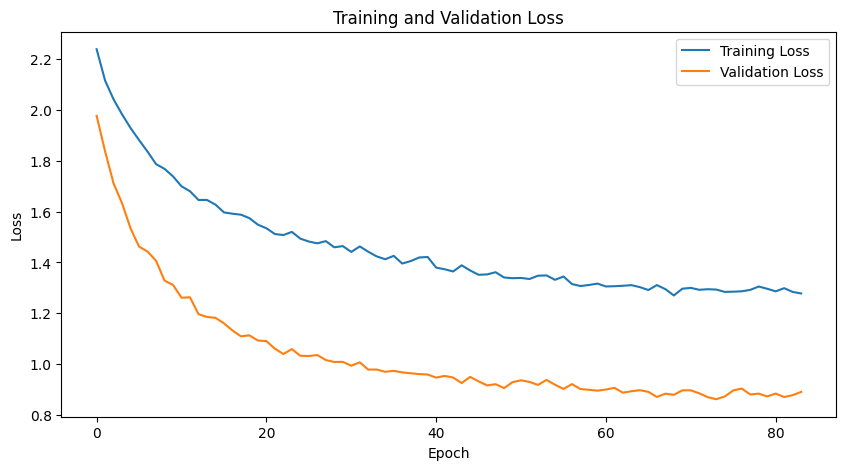

测试集准确率:  90.27%
测试集精确率:  90.41%
测试集召回率:  90.27%
测试集F1分数: 90.26%

分类报告：
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       200
           1       0.95      0.93      0.94       200
           2       0.90      0.92      0.91       140
           3       0.85      0.93      0.89       200
           4       0.97      0.92      0.94       200
           5       0.87      0.96      0.91       160
           6       0.92      0.92      0.92       180
           7       0.91      0.85      0.88       180
           8       0.89      0.81      0.85       200
           9       0.92      0.92      0.92       180

    accuracy                           0.90      1840
   macro avg       0.90      0.90      0.90      1840
weighted avg       0.90      0.90      0.90      1840



/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  fig.canvas.prin

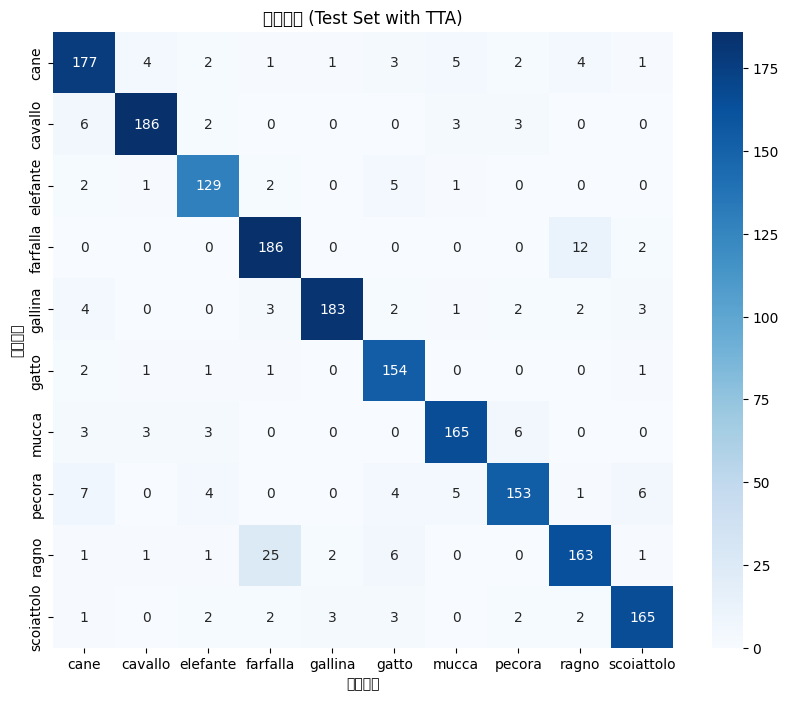

In [10]:

# ========== 训练 & 验证函数  ==========
def train_one_epoch(model, dataloader, optimizer, loss_fn, epoch,
                    mixup_alpha=0.2, cutmix_alpha=0.0, scaler=None):
    """
    单个训练周期函数，包含 MixUp、CutMix 数据增强和混合精度训练。

    参数:
        model: 神经网络模型
        dataloader: 数据加载器 (训练集)
        optimizer: 优化器 (AdamW)
        loss_fn: 损失函数 (LabelSmoothingCrossEntropy)
        epoch: 当前训练周期索引
        mixup_alpha: MixUp 数据增强参数 (控制混合强度)
        cutmix_alpha: CutMix 数据增强参数 (控制裁剪混合强度)
        scaler: 混合精度训练的比例缩放器 (GradScaler)
    """
    model.train()  # 设置模型为训练模式
    epoch_train_loss = 0.0  # 累计训练损失初始化

    loader_tqdm = tqdm(dataloader, desc=f"Training Epoch[{epoch}]", leave=False)  # 进度条显示

    for images, labels in loader_tqdm:
        images, labels = images.to(device), labels.to(device)  # 将数据移动到设备上
        optimizer.zero_grad()  # 清空之前的梯度

        # 开启自动混合精度训练（如果scaler存在）
        with amp.autocast(enabled=(scaler is not None)):
            # 选择 MixUp 或 CutMix 数据增强
            if mixup_alpha > 0.0 and cutmix_alpha > 0.0:
                if random.random() < 0.5:
                    images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
                else:
                    images, y_a, y_b, lam = cutmix_data(images, labels, alpha=cutmix_alpha)
            elif mixup_alpha > 0.0:
                images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            elif cutmix_alpha > 0.0:
                images, y_a, y_b, lam = cutmix_data(images, labels, alpha=cutmix_alpha)
            else:
                lam = 1.0
                y_a, y_b = labels, labels

            outputs = model(images)  # 前向传播
            loss = lam * loss_fn(outputs, y_a) + (1 - lam) * loss_fn(outputs, y_b)  # 计算损失

        # 梯度更新
        if scaler is not None:
            scaler.scale(loss).backward()  # 缩放梯度以防止溢出
            scaler.step(optimizer)  # 更新优化器参数
            scaler.update()  # 调整缩放器比例
        else:
            loss.backward()  # 反向传播
            optimizer.step()  # 更新优化器参数

        epoch_train_loss += loss.item() * images.size(0)  # 记录总损失
        loader_tqdm.set_postfix(loss=loss.item())  # 在进度条中显示当前批次损失

    epoch_train_loss /= len(dataloader.dataset)  # 计算平均损失
    return epoch_train_loss
def val_one_epoch(model, dataloader, loss_fn, epoch):
    """
    单个验证周期函数，评估模型在验证集上的性能。

    参数:
        model: 神经网络模型
        dataloader: 数据加载器 (验证集)
        loss_fn: 损失函数 (LabelSmoothingCrossEntropy)
        epoch: 当前验证周期索引
    """
    model.eval()  # 设置模型为验证模式
    epoch_val_loss = 0.0  # 初始化验证损失
    preds_list = []  # 存储预测结果
    labels_list = []  # 存储真实标签

    loader_tqdm = tqdm(dataloader, desc=f"Validating Epoch[{epoch}]", leave=False)

    with torch.no_grad():  # 禁用梯度计算，减少显存占用
        for images, labels in loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            with amp.autocast():
                outputs = model(images)  # 前向传播
                val_loss = loss_fn(outputs, labels)  # 计算损失

            epoch_val_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)  # 获取预测类别
            preds_list.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            loader_tqdm.set_postfix(loss=val_loss.item())  # 在进度条中显示当前批次损失

    epoch_val_loss /= len(dataloader.dataset)  # 计算平均损失
    val_acc = accuracy_score(labels_list, preds_list)  # 计算准确率
    return epoch_val_loss, val_acc


# ========== 创建模型实例 ==========
model =  LiteIResNet(num_classes=10).to(device)

# ========== 优化器 & 学习率调度器 (使用AdamW + Cosine)
# AdamW：改进版Adam，适合Transformer和现代CNN==========
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)

loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1)

# 早停机制
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

# 混合精度
scaler = amp.GradScaler()

# 开始训练
epochs = 150  # 拉长训练周期，让cosine退火更充分
training_loss_history = []
validation_loss_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss = train_one_epoch(
        model, train_loader, optimizer, loss_fn,
        epoch=epoch,
        mixup_alpha=0.4,       # 可调 (如0.2, 0.4等)
        cutmix_alpha=0.4,      # 可调 (如0.2)
        scaler=scaler
    )
    training_loss_history.append(train_loss)

    val_loss, val_acc = val_one_epoch(model, val_loader, loss_fn, epoch=epoch)
    validation_loss_history.append(val_loss)

    # CosineAnnealing 不学习率采用余弦退火策略，逐渐减小到 eta_min。
    scheduler.step()

    # Early Stopping：连续10个epoch验证损失没有改善则停止训练。保存验证损失最低的模型。
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model1.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plt.figure(figsize=(10,5))
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ========== TTA推理函数 (不变) ==========
def inference_with_tta(model, images, n_augment=5):
    """
    使用 Test-Time Augmentation (TTA) 进行推理。
    指的是对同一图像进行多次不同的数据增强推理，将所有推理结果平均。
    """
    model.eval()
    final_logits = None
    with torch.no_grad():
        for _ in range(n_augment):
            aug_images = images.clone()
            flip_mask = (torch.rand(aug_images.size(0)) > 0.5).to(device)
            for i in range(aug_images.size(0)):
                if flip_mask[i]:
                    aug_images[i] = torch.flip(aug_images[i], dims=[2])
            outputs = model(aug_images)
            final_logits = outputs if final_logits is None else final_logits + outputs
    final_logits = final_logits / n_augment
    return final_logits

# ========== 测试集上评估 ==========
best_model =  LiteIResNet(num_classes=10).to(device)
best_model.load_state_dict(torch.load('best_model1.pth'))
best_model.eval()

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inference_with_tta(best_model, images, n_augment=5)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

print(f"测试集准确率:  {accuracy * 100:.2f}%")
print(f"测试集精确率:  {precision * 100:.2f}%")
print(f"测试集召回率:  {recall * 100:.2f}%")
print(f"测试集F1分数: {f1 * 100:.2f}%\n")

print("分类报告：")
print(classification_report(actual_labels, predicted_labels, zero_division=0))

cm = confusion_matrix(actual_labels, predicted_labels)
class_names = test_dataset.classes
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('混淆矩阵 (Test Set with TTA)')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

